In [1]:
import os
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed = 42
batch_size = 64
epochs = 1 # beacuse we cannot exeed time 12h
lr = 0.023276939100527697
gamma = 0.000709264311831273

residual_dropout = 0.18512537739519747

seed_everything(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device used :", device)

Device used : cuda


In [3]:
# Paths to the dataset
base_dir = '/kaggle/input/ai-vs-human-generated-dataset'
train_csv_path = os.path.join(base_dir, 'train.csv')
test_csv_path  = os.path.join(base_dir, 'test.csv')

# Reading the training CSV file
df_train = pd.read_csv(train_csv_path)
# Example of a row: file_name="train_data/041be3153810...", label=0 or 1

# Reading the testing CSV file
df_test = pd.read_csv(os.path.join(base_dir, 'test.csv'))
# Exemple: df_test['id'] = "test_data_v2/e25323c62af644fba97afb846261b05b.jpg", etc.

# Adding the full path to the file_name instead of just "trainORtest_data/xxx.jpg"
df_test['id'] = df_test['id'].apply(lambda x: os.path.join(base_dir, x))
df_train['file_name'] = df_train['file_name'].apply(lambda x: os.path.join(base_dir, x))

all_image_paths = df_train['file_name'].values
all_labels = df_train['label'].values

# Splitting train/validation (95% / 5%)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_image_paths,
    all_labels,
    test_size=0.05,        
    random_state=seed,
    shuffle=False
)


print(f"Train Data: {len(train_paths)}")
print(f"Validation Data: {len(val_paths)}")

Train Data: 75952
Validation Data: 3998


In [5]:
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode

train_transforms = T.Compose([
    T.Resize(224, interpolation=InterpolationMode.BICUBIC),
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation(20),
    T.GaussianBlur(kernel_size=(7, 13), sigma=(0.1, 1.0)),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

val_transforms = T.Compose([
    T.Resize(224, interpolation=InterpolationMode.BICUBIC),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

test_transforms = T.Compose([
    T.Resize(224, interpolation=InterpolationMode.BICUBIC),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

In [6]:
class ImageDataset(Dataset):
    def __init__(self, file_list, labels=None, transform=None):
        self.file_list = file_list
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        if self.labels is not None:
            label = self.labels[idx]
            return img, label
        else:
            return img

class TestImageDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, os.path.basename(img_path) 

In [7]:
train_data = ImageDataset(train_paths, train_labels, transform=train_transforms)
val_data   = ImageDataset(val_paths,   val_labels,   transform=val_transforms)

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True,  num_workers=4)
val_loader   = DataLoader(dataset=val_data,   batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Train Dataset size: {len(train_data)}")
print(f"Validation Dataset size: {len(val_data)}")

Train Dataset size: 75952
Validation Dataset size: 3998


In [8]:
model = models.efficientnet_v2_m(weights="EfficientNet_V2_M_Weights.DEFAULT")

# Freeze most of the model parameters but unfreeze some layers
for param in model.features.parameters():
    param.requires_grad = False
    
# Unfreeze the last few layers of the features
for param in model.features[-5:].parameters():  
    param.requires_grad = True

model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(p=0.5, inplace=True), 
        nn.Linear(in_features=1280, out_features=256, bias=True),  
        nn.BatchNorm1d(256),  
        nn.ReLU(),  
        nn.Linear(in_features=256, out_features=2, bias=True)  
    ).to(device)

model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth
100%|██████████| 208M/208M [00:00<00:00, 219MB/s]  


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [9]:
# Define loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_f1s = []

In [10]:
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    epoch_accuracy = 0.0

    for data, label in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        data, label = data.to(device), label.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        preds = output.argmax(dim=1)
        acc = (preds == label).float().mean().item()
        epoch_accuracy += acc

    epoch_loss /= len(train_loader)
    epoch_accuracy /= len(train_loader)

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # -- Validation --
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    val_pred_classes = []
    val_labels_list = []

    with torch.no_grad():
        for data, label in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
            data, label = data.to(device), label.to(device)
            output = model(data)

            loss = criterion(output, label)
            val_loss += loss.item()

            preds = output.argmax(dim=1)
            acc = (preds == label).float().mean().item()
            val_acc += acc

            val_pred_classes.extend(preds.cpu().numpy())
            val_labels_list.extend(label.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    
    val_f1 = f1_score(val_labels_list, val_pred_classes)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_f1s.append(val_f1)

    print(
        f"Epoch [{epoch+1}/{epochs}] "
        f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_accuracy:.4f} | "
        f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}"
    )

    scheduler.step()

model_save_path = "efficientnet_v2_m_best.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Validation Epoch 1: 100%|██████████| 63/63 [00:25<00:00,  2.45it/s]


Epoch [1/1] Train Loss: 0.2921 | Train Acc: 0.8696 | Val Loss: 0.1478 | Val Acc: 0.9396 | Val F1: 0.9423
Model saved to efficientnet_v2_m_best.pth


In [11]:
test_dataset = TestImageDataset(df_test['id'].values, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

model.eval()
predictions = []
image_names = []

with torch.no_grad():
    for data, names in tqdm(test_loader, desc="Predicting"):
        data = data.to(device)
        outputs = model(data)
        
        # predict
        preds = outputs.argmax(dim=1)  # shape [batch_size]
        
        predictions.extend(preds.cpu().numpy())
        image_names.extend([f"test_data_v2/{name}" for name in names])

Predicting: 100%|██████████| 87/87 [01:18<00:00,  1.11it/s]


In [ ]:
submission_df = pd.DataFrame({
    'id': image_names,
    'label': predictions
})

In [ ]:
submission_df.head()

In [ ]:
submission_df.to_csv("Effient_netapproachsubmission.csv", index=False)
print("Submission file generated: Effient_netapproachsubmission.csv")

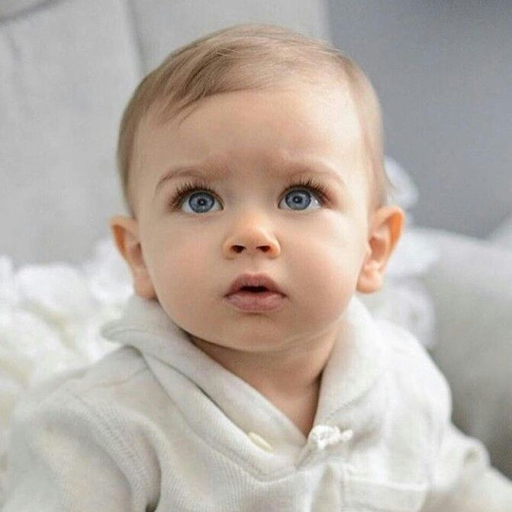

model_index.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

🎨 Generating image, please wait...


  0%|          | 0/30 [00:00<?, ?it/s]

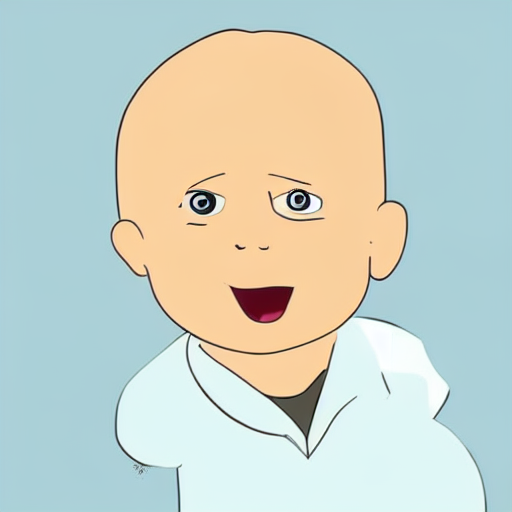


✅ Image saved at /kaggle/working/edited_image.png


In [13]:
# Install required libraries
!pip install diffusers transformers accelerate safetensors

from diffusers import StableDiffusionInstructPix2PixPipeline
import torch
from PIL import Image
from IPython.display import display

# ===============================
# 1️⃣ Load Image
# ===============================
# Put your image in the Kaggle notebook input folder, e.g., "/kaggle/input/my-images/dog.jpeg"
image_path = "/kaggle/input/boy123/boy.jpg"  # change path as per your dataset
init_image = Image.open(image_path).convert("RGB")
init_image = init_image.resize((512, 512))

# Display image inline
display(init_image)

# ===============================
# 2️⃣ Load Model
# ===============================
model_id = "timbrooks/instruct-pix2pix"
device = "cuda" if torch.cuda.is_available() else "cpu"

pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
    safety_checker=None
).to(device)

# ===============================
# 3️⃣ Set Prompt
# ===============================
prompt = "Make this child look like a cartoon"  # <-- change this to whatever you want

# ===============================
# 4️⃣ Generate Modified Image
# ===============================
print("🎨 Generating image, please wait...")
edited_image = pipe(
    prompt=prompt,
    image=init_image,
    num_inference_steps=30,
    image_guidance_scale=1.2
).images[0]

# ===============================
# 5️⃣ Display and Save Result
# ===============================
display(edited_image)

# Save locally in Kaggle output
edited_image.save("/kaggle/working/edited_image.png")
print("\n✅ Image saved at /kaggle/working/edited_image.png")


In [14]:
model.eval()

# ====================================================
# 5️⃣ Define transforms (adjust as per your training pipeline)
# ====================================================
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# ====================================================
# 6️⃣ Define prediction function
# ====================================================
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = test_transforms(image).unsqueeze(0).to(device)  # shape: [1, 3, 224, 224]
    
    with torch.no_grad():
        outputs = model(image)
        probs = torch.softmax(outputs, dim=1)[0]
        pred_class = outputs.argmax(dim=1).item()
    
    # Assuming 0 = real, 1 = AI-generated (change if opposite)
    label = "AI-generated" if pred_class == 1 else "Real"
    confidence = probs[pred_class].item()
    
    print(f"🖼️ Image: {image_path}")
    print(f"→ Prediction: {label} ({confidence*100:.2f}% confidence)\n")

# ====================================================
# 7️⃣ Test on your two images
# ====================================================
img1_path = "/kaggle/input/boy123/boy.jpg"
img2_path = "/kaggle/working/edited_image.png"

predict_image(img1_path)
predict_image(img2_path)

🖼️ Image: /kaggle/input/boy123/boy.jpg
→ Prediction: Real (99.98% confidence)

🖼️ Image: /kaggle/working/edited_image.png
→ Prediction: AI-generated (67.77% confidence)

